### 【 네이버 박스오피스 웹 크롤링 분석하기 】
[2025_11_22]_CRAWING_SCRAPING_웹 데이터 추출 및 분석

웹 데이터 추출 및 분석
- 네이버 박스오피스 영화 크롤링 및 분석

[1] 모듈 불러오기 <hr>

In [32]:
from urllib.request import urlopen, Request
from urllib.parse import urljoin
from bs4 import BeautifulSoup
import pandas as pd

[2] 박스오피스 목록 페이지에서 15개 영화 기본 정보 수집 <hr>

In [ ]:
BOX_URL = "https://search.naver.com/search.naver?where=nexearch&sm=tab_etc&qvt=0&query=%EB%B0%95%EC%8A%A4%EC%98%A4%ED%94%BC%EC%8A%A4"
HEADERS = {"User-Agent": "Mozilla/5.0"}

def get_soup(url: str) -> BeautifulSoup:
    req = Request(url, headers=HEADERS)
    res = urlopen(req)
    return BeautifulSoup(res, "html.parser")

# 1) 박스오피스 페이지 파싱
soup = get_soup(BOX_URL)

# 2) 첫 번째 영화 패널 안의 li 15개 선택
panel = soup.select_one("div.list_image_box ul._panel")
movies = panel.select("li")

print("목록에서 찾은 영화 개수:", len(movies))

# 3) 각 li에서 순위 / 제목 / (간단) 관객 / 상세 링크 추출
movie_list = []

for mv in movies:
    rank_tag     = mv.select_one("span.cm_thumb_rank_number span.this_text")
    title_tag    = mv.select_one("strong.name")
    audience_tag = mv.select_one("span.sub_text")
    link_tag     = mv.select_one("a.inner")

    if not (rank_tag and title_tag and link_tag):
        continue

    rank     = rank_tag.get_text(strip=True)
    title    = title_tag.get_text(strip=True)
    audience = audience_tag.get_text(strip=True) if audience_tag else None
    href     = link_tag["href"]

    detail_url = urljoin(BOX_URL, href)

    movie_list.append({
        "rank": rank,
        "title": title,
        "audience_list": audience,
        "detail_url": detail_url
    })

print("상세 링크까지 모은 영화 개수:", len(movie_list)) # 15개 잘 나오나 확인
print(movie_list[0])  # 1위 영화 출력해서 한 번 확인해보기

목록에서 찾은 영화 개수: 15
상세 링크까지 모은 영화 개수: 15
{'rank': '1', 'title': '위키드: 포 굿', 'audience_list': '16만명', 'detail_url': 'https://search.naver.com/search.naver?where=nexearch&sm=tab_etc&mra=bkEw&pkid=68&os=37041608&qvt=0&query=%EC%9C%84%ED%82%A4%EB%93%9C%3A%20%ED%8F%AC%20%EA%B5%BF'}


[3] 상세 페이지에서 개요 / 관객 / 평점 추출 함수들 만들기 <hr>

In [34]:
import math

# selector들을 '루트만 빼고' 상대경로로 단축
# (이렇게 해야 1위 영화 + 나머지 영화 페이지에 공통으로 더 잘 먹힘)

RANK_AUD_SELECTOR       = "div.custom_info_wrap > div > div > div:nth-child(1) > div"
REAL_RATING_SELECTOR    = "div.custom_info_wrap > div > div > div:nth-child(2) > div"
NET_RATING_SELECTOR     = "div.custom_info_wrap > div > div > div:nth-child(3) > div"
OVERVIEW_SELECTOR       = "div.detail_info > dl > div:nth-child(1) > dd"

def parse_rank_audience(text: str):
    """
    예: '순위 누적 관객수 1 위 / 40 만명' -> ('1위', '40만명')
    """
    if not text:
        return None, None

    clean = text.replace(" ", "")      # '순위누적관객수1위/40만명'
    parts = clean.split("/")           # ['순위누적관객수1위', '40만명']
    rank_part = parts[0]
    aud_part  = parts[1] if len(parts) > 1 else ""

    # 숫자들만 골라서 '위' 붙이기
    rank_digits = "".join(ch for ch in rank_part if ch.isdigit())
    rank = rank_digits + "위" if rank_digits else None

    audience = aud_part or None
    return rank, audience

def parse_overview(text: str):
    """
    예: '개요 판타지 · 137분' 또는 '개요 판타지 137분' -> ('판타지', '137분')
    """
    if not text:
        return None, None

    txt = text.strip()
    if txt.startswith("개요"):
        txt = txt[2:].strip()

    if "·" in txt:
        genre_part, time_part = [t.strip() for t in txt.split("·", 1)]
    else:
        parts = txt.split()
        if len(parts) >= 2:
            time_part = parts[-1]
            genre_part = " ".join(parts[:-1])
        else:
            genre_part = txt
            time_part = None

    return genre_part, time_part

def parse_rating_box(text: str):
    """
    예: '실관람객 평점 7.56' or '네티즌 평점 6.83' -> 7.56, 6.83 (float)
    """
    if not text:
        return math.nan

    num_str = "".join(ch for ch in text if (ch.isdigit() or ch == "."))
    try:
        return float(num_str)
    except ValueError:
        return math.nan

[4] 15개 영화 상세 페이지 돌면서 데이터프레임 만들기 <hr>

In [ ]:
movie_data = []

for m in movie_list:
    url = m["detail_url"]
    detail = get_soup(url)

    # 1) 순위 / 누적 관객수
    rank_aud_tag = detail.select_one(RANK_AUD_SELECTOR)
    rank_text = rank_aud_tag.get_text(" ", strip=True) if rank_aud_tag else ""
    rank_detail, audience_detail = parse_rank_audience(rank_text)

    # 2) 개요 (장르 + 상영시간)
    overview_tag = detail.select_one(OVERVIEW_SELECTOR)
    overview_text = overview_tag.get_text(" ", strip=True) if overview_tag else ""
    genre, time_str = parse_overview(overview_text)

    # 3) 실관람객 / 네티즌 평점
    real_tag = detail.select_one(REAL_RATING_SELECTOR)
    net_tag  = detail.select_one(NET_RATING_SELECTOR)

    real_text = real_tag.get_text(" ", strip=True) if real_tag else ""
    net_text  = net_tag.get_text(" ", strip=True) if net_tag else ""

    real_rating = parse_rating_box(real_text)
    net_rating  = parse_rating_box(net_text)

    movie_data.append({
        "순위": rank_detail,       # 상세 기준 순위 (없으면 None)
        "제목": m["title"],
        "주간 관객 수": m["audience_list"],   # 목록의 대략 관객 ('16만명' 등)
        "누적 관객 수": audience_detail,    # 상세의 관객 ('40만명' 등, 없으면 None)
        "장르": genre,
        "상영시간": time_str,
        "실관람객 평점": real_rating,
        "네티즌 평점": net_rating,
    })

[5] 데이터프레임 만들어서 출력해보기 <hr>

In [41]:
df = pd.DataFrame(movie_data)
df

,순위,제목,주간 관객 수,누적 관객 수,장르,상영시간,실관람객 평점,네티즌 평점
0,1위,위키드: 포 굿,16만명,40만명,판타지,137분,7.54,6.85
1,2위,나우 유 씨 미 3,10만명,92만명,범죄 미국,112분,7.84,7.23
2,3위,극장판 체인소 맨: 레제편,2.7만명,325만명,애니메이션 일본,100분,9.27,9.36
3,4위,국보,1.4만명,4.5만명,드라마,175분,9.10,9.55
4,5위,프레데터: 죽음의 땅,1만명,40만명,SF 미국,107분,8.62,9.13
5,6위,나혼자 프린스,"8,982명",2.8만명,코미디 대한민국,116분,7.53,7.30
6,7위,퍼스트 라이드,"5,451명",72만명,코미디 대한민국,116분,7.57,5.53
7,8위,세계의 주인,"5,329명",12만명,드라마 대한민국,119분,9.08,9.21
8,9위,극장판 귀멸의 칼날: 무한성편,"5,185명",564만명,애니메이션 일본,155분,9.03,9.14
9,10위,극장판 똘똘이: 아기공룡의 ...,"2,631명",3.3만명,애니메이션,78분,8.14,9.23


### 영화 시각화해서 분석해보기

1. “요즘 관객수 많은 영화 장르” 분석

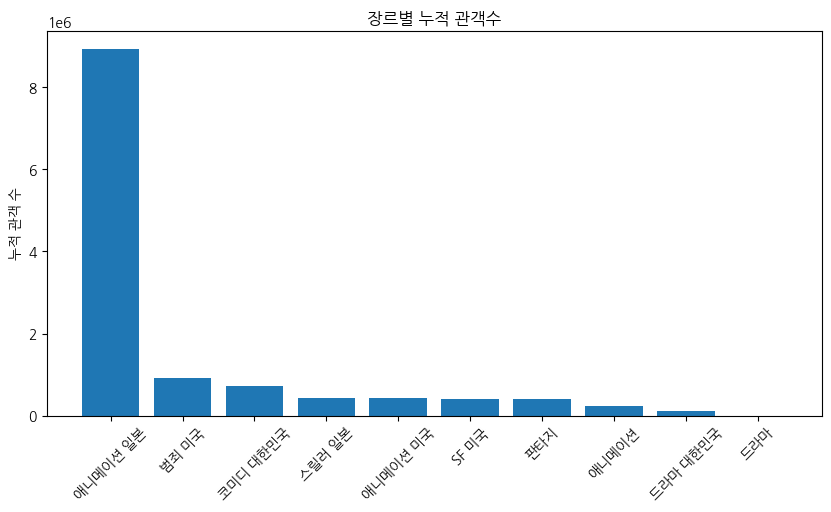

In [44]:
import matplotlib.pyplot as plt
import koreanize_matplotlib

df["누적 관객 수(숫자)"] = df["누적 관객 수"].str.replace("만명","0000").str.replace("명","").str.replace(",","").astype(float)

genre_audience = df.groupby("장르")["누적 관객 수(숫자)"].sum().sort_values(ascending=False)

plt.figure(figsize=(10,5))
plt.bar(genre_audience.index, genre_audience.values)
plt.title("장르별 누적 관객수")
plt.xticks(rotation=45)
plt.ylabel("누적 관객 수")
plt.show()


결론 : 일본 애니메이션이 한국에서 가장 인기를 끌고 있다

2. 평점이 높은 영화 장르 (산점도)

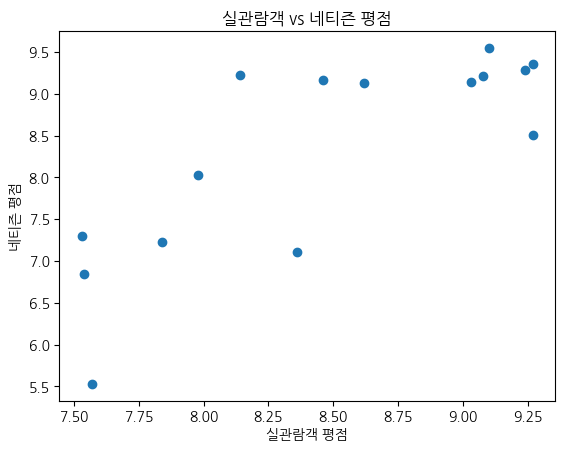

In [45]:
plt.scatter(df["실관람객 평점"], df["네티즌 평점"])
plt.xlabel("실관람객 평점")
plt.ylabel("네티즌 평점")
plt.title("실관람객 vs 네티즌 평점")
plt.show()

두 평점은 전반적으로 양의 상관관계를 보인다.

3. 순위와 평점의 관계 (상관계수)

In [46]:
df["순위(숫자)"] = df["순위"].str.replace("위","").astype(int)

df_corr = df[["순위(숫자)", "실관람객 평점", "네티즌 평점"]].corr()
print(df_corr)


           순위(숫자)  실관람객 평점    네티즌 평점
순위(숫자)   1.000000  0.25773  0.211115
실관람객 평점  0.257730  1.00000  0.793900
네티즌 평점   0.211115  0.79390  1.000000


순위와 평점의 상관계수는 낮아 흥행 순위가 평점의 영향을 크게 받지는 않는다.
즉, 평점이 높다고 해서 1위를 하는 것은 아니다.

4. 영화 길이(상영시간)와 관객수/평점의 관계

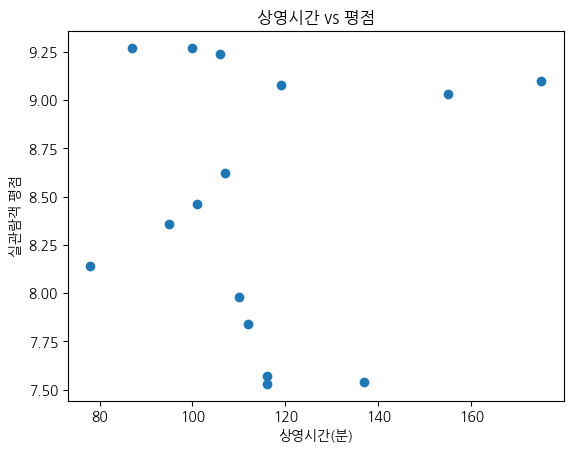

In [47]:
df["상영시간(분)"] = df["상영시간"].str.replace("분","").astype(int)
plt.scatter(df["상영시간(분)"], df["실관람객 평점"])
plt.xlabel("상영시간(분)")
plt.ylabel("실관람객 평점")
plt.title("상영시간 vs 평점")
plt.show()

상영시간은 평점에 크게 영향을 미지치 않는다고 볼 수 있다.

### 결론

요즘 박스오피스 상위권은 ‘애니메이션·판타지’ 장르 중심의 흥행 흐름이 나타난다.
특히 <체인소맨>, <귀멸의 칼날>, <위키드> 등 시리즈 혹은 IP 기반 콘텐츠의 누적 관객수가 매우 높다.

관객수와 평점의 직접적인 상관관계는 낮지만, 드라마와 애니메이션 장르는 높은 평점 분포를 보이며 작품성 면에서 우수한 평가를 받고 있다.
반대로 코미디·액션 장르는 누적 관객수에 비해 평점이 다소 낮게 나타난다.

전체적으로 보면
“시리즈/애니메이션 중심의 흥행”, “평점 높은 작품 = 드라마/애니”, “상영시간은 100~120분대가 표준”
이라는 트렌드를 확인할 수 있다!